# 제품 이상여부 판별 프로젝트


## 1. 데이터 불러오기


### 필수 라이브러리


In [946]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### 데이터 읽어오기


In [947]:
RANDOM_STATE = 110

train_data = pd.read_csv("../../data/trim_train_data.csv")
test_data = pd.read_csv("../../data/trim_test_data.csv")

---

반복적으로 쓰는 툴 함수화

In [948]:
def plot_box(df, col_name):
    """
    주어진 데이터프레임과 열 이름에 대해 박스 플롯을 그리는 함수.

    Parameters:
    dataframe (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    """
    plt.figure(figsize=(7, 4))
    plt.boxplot(df[col_name], vert=False)
    plt.xlabel(col_name)
    plt.title(f'Box Plot of {col_name}')
    plt.show()

In [949]:
def value_counts_ratio(df, col_name, target_name='target'):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

In [950]:
def summarize_group(df, group_by_columns):
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # 'target' 변수의 'AdNormal' 비율과 갯수 계산
        adnormal_count = group['target'].value_counts().get('AbNormal', 0)
        adnormal_ratio = adnormal_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, adnormal_count, adnormal_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'AdNormal' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)

# 예시코드
# summarize_grouped_data(train_data, ['1st Pressure Collect Result_AutoClave', '1st Pressure Unit Time_AutoClave'])

In [951]:
def plot_ratio(df, group_by_column, target_column='target', abnormal_value='AbNormal'):
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_column)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # 'target' 변수의 'AbNormal' 비율과 갯수 계산
        abnormal_count = group[target_column].value_counts().get(abnormal_value, 0)
        abnormal_ratio = abnormal_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, abnormal_count, abnormal_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', f"'{abnormal_value}' count", 'ratio', 'Total'])
    
    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))
    
    # 막대 그래프 생성
    ax = results_df.plot(kind='bar', x='group', y='ratio', legend=False)
    
    # 각 막대 위에 AbNormal 갯수와 총 갯수 표시
    for i, (abnormal_count, total) in enumerate(zip(results_df[f"'{abnormal_value}' count"], results_df['Total'])):
        ax.text(i, results_df['ratio'][i], f'{abnormal_count} ({total})', ha='center', va='bottom', fontsize=8)
    
     # 그래프 제목 및 축 레이블 설정
    ax.set_title(f'{abnormal_value} Ratio by {group_by_column}')
    ax.set_xlabel(group_by_column)
    ax.set_ylabel(f'{abnormal_value} Ratio')
   
    # 그래프 출력
    plt.show()

---

## AutoClave

In [952]:
# 오타인 변수명 변경
train_data = train_data.rename(columns={'1st Pressure 1st Pressure Unit Time_AutoClave': '1st Pressure Unit Time_AutoClave'})
test_data = test_data.rename(columns={'1st Pressure 1st Pressure Unit Time_AutoClave': '1st Pressure Unit Time_AutoClave'})

In [953]:
# '_AutoClave'를 포함하는 열 이름 필터링
train_data.filter(like='_AutoClave').columns

Index(['Wip Line_AutoClave', 'Process Desc._AutoClave', 'Equipment_AutoClave',
       'Model.Suffix_AutoClave', 'Workorder_AutoClave',
       'Insp. Seq No._AutoClave', 'Insp Judge Code_AutoClave',
       '1st Pressure Collect Result_AutoClave',
       '1st Pressure Unit Time_AutoClave',
       '1st Pressure Judge Value_AutoClave',
       '2nd Pressure Collect Result_AutoClave',
       '2nd Pressure Unit Time_AutoClave',
       '2nd Pressure Judge Value_AutoClave',
       '3rd Pressure Collect Result_AutoClave',
       '3rd Pressure Unit Time_AutoClave',
       '3rd Pressure Judge Value_AutoClave',
       'Chamber Temp. Collect Result_AutoClave',
       'Chamber Temp. Unit Time_AutoClave',
       'Chamber Temp. Judge Value_AutoClave',
       'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
       'GMES_ORIGIN_INSP_JUDGE_CODE Unit Time_AutoClave',
       'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave'],
      dtype='object')

fill 공정 관련 변수중 모든값이 결측값인 경우 drop

In [954]:
# target 열을 임시로 분리
target_train = train_data['target']
target_test = test_data['target']

# '_AutoClave'이 포함된 열만 필터링
fill_columns_train = [col for col in train_data.columns if '_AutoClave' in col]
fill_columns_test = [col for col in test_data.columns if '_AutoClave' in col]

# 모든 값이 NaN인 '_fill' 열 제거
train_data = train_data.drop(columns=[col for col in fill_columns_train if train_data[col].isna().all()])
test_data = test_data.drop(columns=[col for col in fill_columns_test if test_data[col].isna().all()])

# target 열을 다시 결합
train_data['target'] = target_train
test_data['target'] = target_test

In [955]:
# '_AutoClave'를 포함하는 열 이름 필터링
train_data.filter(like='_AutoClave').columns

Index(['Wip Line_AutoClave', 'Process Desc._AutoClave', 'Equipment_AutoClave',
       'Model.Suffix_AutoClave', 'Workorder_AutoClave',
       'Insp. Seq No._AutoClave', 'Insp Judge Code_AutoClave',
       '1st Pressure Collect Result_AutoClave',
       '1st Pressure Unit Time_AutoClave',
       '1st Pressure Judge Value_AutoClave',
       '2nd Pressure Collect Result_AutoClave',
       '2nd Pressure Unit Time_AutoClave',
       '2nd Pressure Judge Value_AutoClave',
       '3rd Pressure Collect Result_AutoClave',
       '3rd Pressure Unit Time_AutoClave',
       '3rd Pressure Judge Value_AutoClave',
       'Chamber Temp. Collect Result_AutoClave',
       'Chamber Temp. Unit Time_AutoClave',
       'Chamber Temp. Judge Value_AutoClave',
       'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
       'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave'],
      dtype='object')

In [956]:
value_counts_ratio(train_data, 'Wip Line_AutoClave')


Wip Line_AutoClave별 target 비율 및 갯수

          AbNormal    Normal  AbNormal  Normal  Total
variable                                             
IVI-OB6   0.058016  0.941984      2350   38156  40506


In [957]:
value_counts_ratio(train_data, 'Process Desc._AutoClave')


Process Desc._AutoClave별 target 비율 및 갯수

                AbNormal    Normal  AbNormal  Normal  Total
variable                                                   
Auto Clave Out  0.058016  0.941984      2350   38156  40506


In [958]:
value_counts_ratio(train_data, 'Equipment_AutoClave')


Equipment_AutoClave별 target 비율 및 갯수

                AbNormal    Normal  AbNormal  Normal  Total
variable                                                   
Auto Clave Out  0.058016  0.941984      2350   38156  40506


단일 고윳값 제거

In [959]:
# 삭제할 열 이름 정의
columns_to_drop = [
    'Wip Line_AutoClave'
    , 'Process Desc._AutoClave'
    , 'Equipment_AutoClave'
]

# train_data에서 열 삭제
train_data = train_data.drop(columns=columns_to_drop)

# test_data에서 열 삭제
test_data = test_data.drop(columns=columns_to_drop)

In [960]:
# '_AutoClave'를 포함하는 열 이름 필터링
train_data.filter(like='_AutoClave').columns

Index(['Model.Suffix_AutoClave', 'Workorder_AutoClave',
       'Insp. Seq No._AutoClave', 'Insp Judge Code_AutoClave',
       '1st Pressure Collect Result_AutoClave',
       '1st Pressure Unit Time_AutoClave',
       '1st Pressure Judge Value_AutoClave',
       '2nd Pressure Collect Result_AutoClave',
       '2nd Pressure Unit Time_AutoClave',
       '2nd Pressure Judge Value_AutoClave',
       '3rd Pressure Collect Result_AutoClave',
       '3rd Pressure Unit Time_AutoClave',
       '3rd Pressure Judge Value_AutoClave',
       'Chamber Temp. Collect Result_AutoClave',
       'Chamber Temp. Unit Time_AutoClave',
       'Chamber Temp. Judge Value_AutoClave',
       'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
       'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave'],
      dtype='object')

In [961]:
value_counts_ratio(train_data, 'Model.Suffix_AutoClave')


Model.Suffix_AutoClave별 target 비율 및 갯수

             AbNormal    Normal  AbNormal  Normal  Total
variable                                                
AJX75334501  0.056712  0.943288      1918   31902  33820
AJX75334502  0.067847  0.932153       230    3160   3390
AJX75334503  0.271605  0.728395        44     118    162
AJX75334505  0.049336  0.950664       130    2505   2635
AJX75334506  0.062016  0.937984         8     121    129
AJX75334507  0.058065  0.941935        18     292    310
AJX75334508  0.033333  0.966667         2      58     60


In [962]:
# value_counts_ratio(train_data, 'Workorder_AutoClave')

In [963]:
# 'Workorder_AutoClave' 열에서 '-' 다음 숫자 값 추출 및 '000' 제거
train_data['Workorder_AutoClave'] = train_data['Workorder_AutoClave'].str.replace(r'-(\d+)', lambda x: '-' + x.group(1).lstrip('0'), regex=True)

xxxxx-0001 -> xxxxx-1 변환 코드

In [964]:
value_counts_ratio(train_data, 'Insp. Seq No._AutoClave')


Insp. Seq No._AutoClave별 target 비율 및 갯수

          AbNormal    Normal  AbNormal  Normal  Total
variable                                             
1         0.058016  0.941984      2350   38156  40506


In [965]:
value_counts_ratio(train_data, 'Insp Judge Code_AutoClave')


Insp Judge Code_AutoClave별 target 비율 및 갯수

          AbNormal    Normal  AbNormal  Normal  Total
variable                                             
OK        0.058016  0.941984      2350   38156  40506


In [966]:
summarize_group(train_data, [
    'Insp. Seq No._AutoClave'
    , 'Insp Judge Code_AutoClave'
    ])

Grouped by: Insp. Seq No._AutoClave, Insp Judge Code_AutoClave

     group  'AdNormal' count     ratio  Total
0  (1, OK)              2350  0.058016  40506


Insp. Seq No._AutoClave, Insp Judge Code_AutoClave 둘다 단일 고윳값  
-> drop

In [967]:
# 삭제할 열 이름 정의
columns_to_drop = [
    'Insp. Seq No._AutoClave'
    , 'Insp Judge Code_AutoClave'
    ]

# train_data에서 열 삭제
train_data = train_data.drop(columns=columns_to_drop)

# test_data에서 열 삭제
test_data = test_data.drop(columns=columns_to_drop)

In [968]:
# '_AutoClave'를 포함하는 열 이름 필터링
train_data.filter(like='_AutoClave').columns

Index(['Model.Suffix_AutoClave', 'Workorder_AutoClave',
       '1st Pressure Collect Result_AutoClave',
       '1st Pressure Unit Time_AutoClave',
       '1st Pressure Judge Value_AutoClave',
       '2nd Pressure Collect Result_AutoClave',
       '2nd Pressure Unit Time_AutoClave',
       '2nd Pressure Judge Value_AutoClave',
       '3rd Pressure Collect Result_AutoClave',
       '3rd Pressure Unit Time_AutoClave',
       '3rd Pressure Judge Value_AutoClave',
       'Chamber Temp. Collect Result_AutoClave',
       'Chamber Temp. Unit Time_AutoClave',
       'Chamber Temp. Judge Value_AutoClave',
       'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
       'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave'],
      dtype='object')

분석에 앞서 OK 값을 가지는 변수들에 대한 처리를 먼저 진행

In [969]:
summarize_group(train_data, [
    '1st Pressure Judge Value_AutoClave'
    , '2nd Pressure Judge Value_AutoClave'
    , '3rd Pressure Judge Value_AutoClave'])

Grouped by: 1st Pressure Judge Value_AutoClave, 2nd Pressure Judge Value_AutoClave, 3rd Pressure Judge Value_AutoClave

          group  'AdNormal' count     ratio  Total
0  (OK, OK, OK)              2350  0.058016  40506


모든 값 OK 값 -> drop

In [970]:
# 삭제하려는 열 목록
columns_to_drop = [
    '1st Pressure Judge Value_AutoClave'
    , '2nd Pressure Judge Value_AutoClave'
    , '3rd Pressure Judge Value_AutoClave']

# train_data에서 열 삭제
train_data = train_data.drop(columns=[col for col in columns_to_drop if col in train_data.columns])

# test_data에서 열 삭제
test_data = test_data.drop(columns=[col for col in columns_to_drop if col in test_data.columns])

4개의 변수 모두 동일 행에 대해서 ok 값을 가짐

In [971]:
summarize_group(train_data, [
    'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'
    ,'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave'])

Grouped by: GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave, GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave

      group  'AdNormal' count     ratio  Total
0  (OK, OK)               496  0.043921  11293


위의 Ok 값은 초기 밀려진 데이터에 대해서 생성된 값으로 판단  
-> drop

In [972]:
# 삭제하려는 열 목록
columns_to_drop = [
    'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'
    , 'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave']

# train_data에서 열 삭제
train_data = train_data.drop(columns=[col for col in columns_to_drop if col in train_data.columns])

# test_data에서 열 삭제
test_data = test_data.drop(columns=[col for col in columns_to_drop if col in test_data.columns])

In [973]:
train_data['Chamber Temp. Judge Value_AutoClave'].value_counts()

OK    29112
NG    11394
Name: Chamber Temp. Judge Value_AutoClave, dtype: int64

Chamber Temp. Judge Value_AutoClave 변수명 Chamber_Temp_OKNG_AutoClave으로 변경  
-> 변수명 간결화 목적

In [974]:
# 'Chamber_Temp_OKNG_AutoClave' 변수 추가
train_data['Chamber_Temp_OKNG_AutoClave'] = train_data['Chamber Temp. Judge Value_AutoClave']
test_data['Chamber_Temp_OKNG_AutoClave'] = test_data['Chamber Temp. Judge Value_AutoClave']

# 'Chamber_Temp_OKNG_AutoClave' 열의 값을 'OK'는 1, 'NG'는 0으로 변환
train_data['Chamber_Temp_OKNG_AutoClave'] = train_data['Chamber Temp. Judge Value_AutoClave'].map({'OK': 1, 'NG': 0})
test_data['Chamber_Temp_OKNG_AutoClave'] = test_data['Chamber Temp. Judge Value_AutoClave'].map({'OK': 1, 'NG': 0})

# 변환된 값 확인
print(train_data['Chamber_Temp_OKNG_AutoClave'].value_counts())

# 'Chamber Temp. Judge Value_AutoClave' 열 삭제
train_data.drop(columns=['Chamber Temp. Judge Value_AutoClave'], inplace=True)
test_data.drop(columns=['Chamber Temp. Judge Value_AutoClave'], inplace=True)

1    29112
0    11394
Name: Chamber_Temp_OKNG_AutoClave, dtype: int64


In [975]:
# '_AutoClave'를 포함하는 열 이름 필터링
train_data.filter(like='_AutoClave').columns

Index(['Model.Suffix_AutoClave', 'Workorder_AutoClave',
       '1st Pressure Collect Result_AutoClave',
       '1st Pressure Unit Time_AutoClave',
       '2nd Pressure Collect Result_AutoClave',
       '2nd Pressure Unit Time_AutoClave',
       '3rd Pressure Collect Result_AutoClave',
       '3rd Pressure Unit Time_AutoClave',
       'Chamber Temp. Collect Result_AutoClave',
       'Chamber Temp. Unit Time_AutoClave', 'Chamber_Temp_OKNG_AutoClave'],
      dtype='object')

### EDA : Pressure 

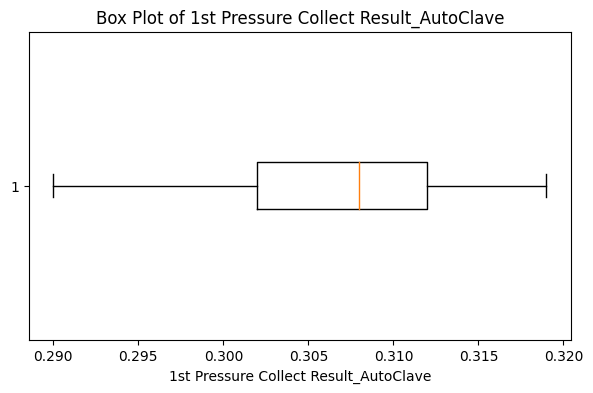

In [976]:
plot_box(train_data, '1st Pressure Collect Result_AutoClave')

boxplot 그래프에 점의 값 존재 x (IQR * 1.5 이상의 값 존재 x)  
-> 이상치 존재 x

<Figure size 1000x500 with 0 Axes>

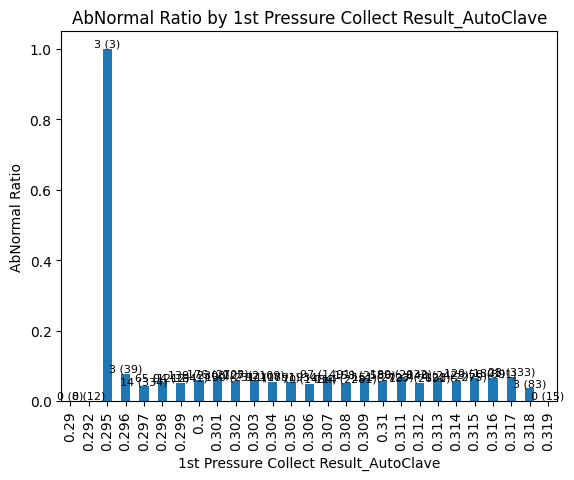

In [977]:
plot_ratio(train_data, '1st Pressure Collect Result_AutoClave')

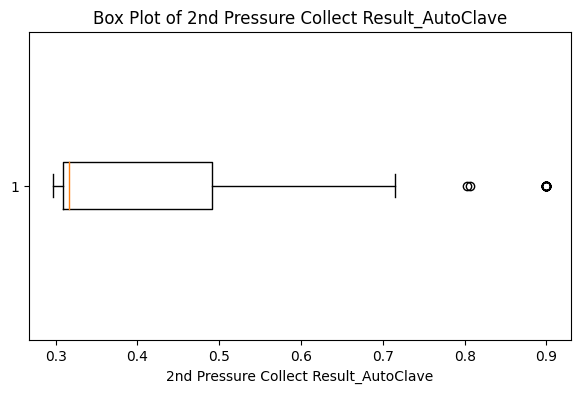

In [978]:
plot_box(train_data, '2nd Pressure Collect Result_AutoClave')

<Figure size 1000x500 with 0 Axes>

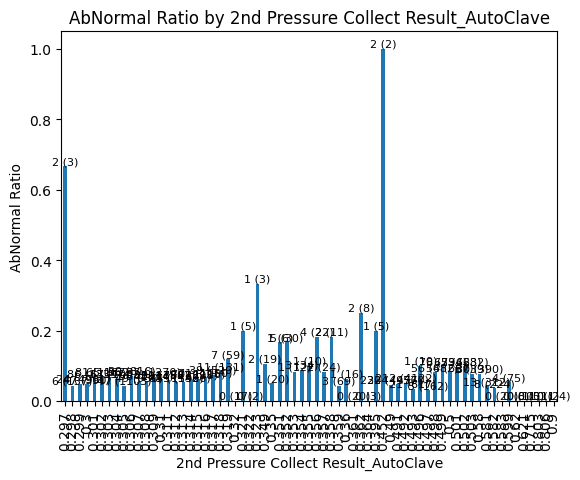

In [979]:
plot_ratio(train_data, '2nd Pressure Collect Result_AutoClave')

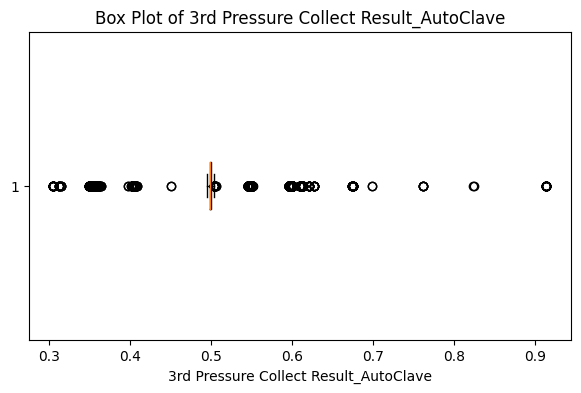

In [980]:
plot_box(train_data, '3rd Pressure Collect Result_AutoClave')

In [981]:
# value_counts_ratio(train_data, '3rd Pressure Collect Result_AutoClave')

<Figure size 1000x500 with 0 Axes>

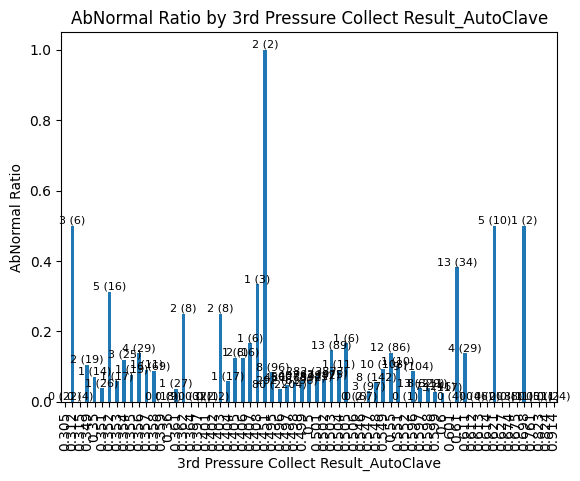

In [982]:
plot_ratio(train_data, '3rd Pressure Collect Result_AutoClave')

압력(Pressure) 1차,2차,3차 변수에 대해서 boxplot과 타겟변수비율을 확인하였을때 유의미함을 찾지 못함  
-> 다른 변수와의 결합으로 유의미해질것으로 판단

In [983]:
# '_AutoClave'를 포함하는 열 이름 필터링
train_data.filter(like='_AutoClave').columns

Index(['Model.Suffix_AutoClave', 'Workorder_AutoClave',
       '1st Pressure Collect Result_AutoClave',
       '1st Pressure Unit Time_AutoClave',
       '2nd Pressure Collect Result_AutoClave',
       '2nd Pressure Unit Time_AutoClave',
       '3rd Pressure Collect Result_AutoClave',
       '3rd Pressure Unit Time_AutoClave',
       'Chamber Temp. Collect Result_AutoClave',
       'Chamber Temp. Unit Time_AutoClave', 'Chamber_Temp_OKNG_AutoClave'],
      dtype='object')

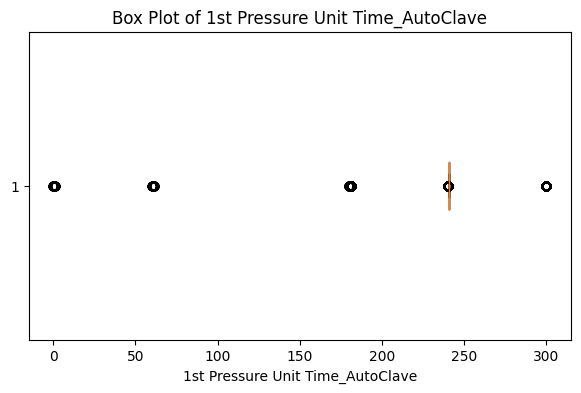

In [984]:
plot_box(train_data, '1st Pressure Unit Time_AutoClave')

<Figure size 1000x500 with 0 Axes>

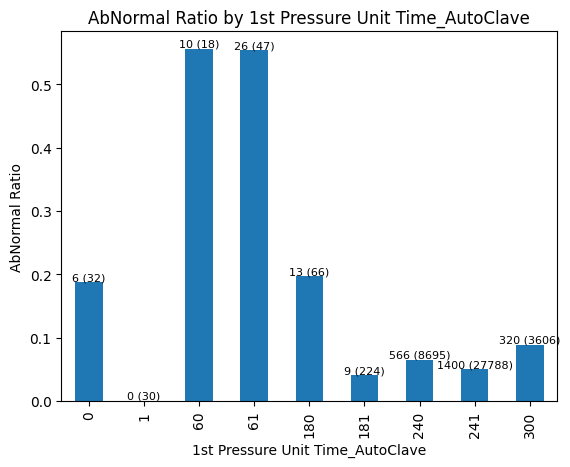

In [985]:
plot_ratio(train_data, '1st Pressure Unit Time_AutoClave')

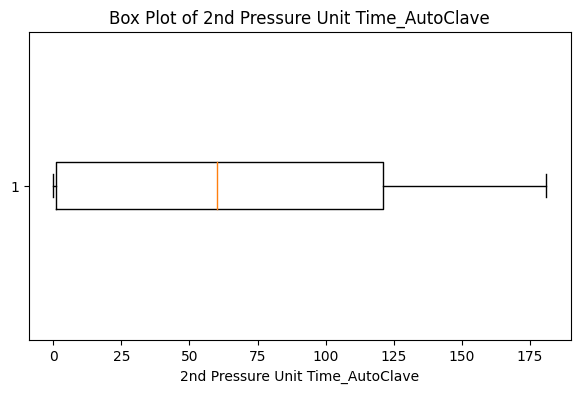

In [986]:
plot_box(train_data, '2nd Pressure Unit Time_AutoClave')

<Figure size 1000x500 with 0 Axes>

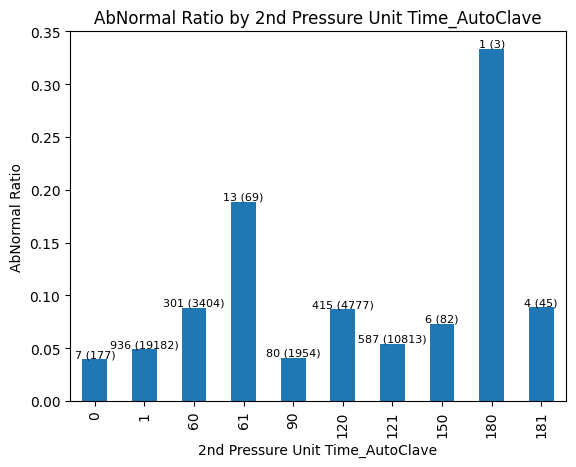

In [987]:
plot_ratio(train_data, '2nd Pressure Unit Time_AutoClave')

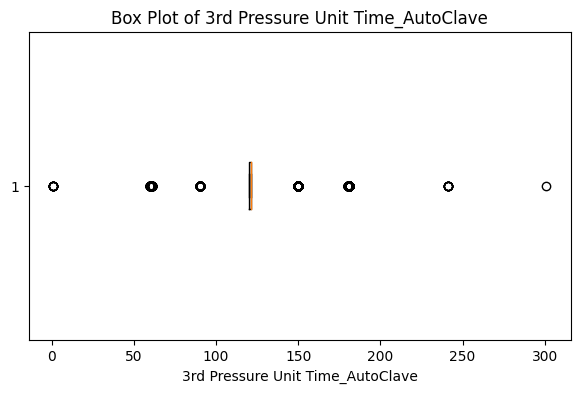

In [988]:
plot_box(train_data, '3rd Pressure Unit Time_AutoClave')

<Figure size 1000x500 with 0 Axes>

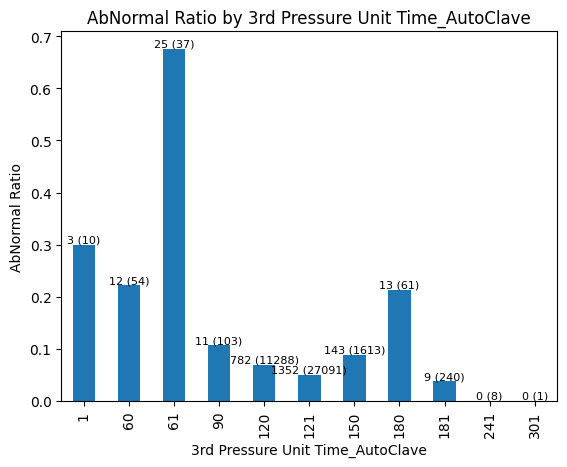

In [989]:
plot_ratio(train_data, '3rd Pressure Unit Time_AutoClave')

In [990]:
summarize_group(train_data, [
    '1st Pressure Unit Time_AutoClave'
    , '2nd Pressure Unit Time_AutoClave'
    , '3rd Pressure Unit Time_AutoClave'
    ])

Grouped by: 1st Pressure Unit Time_AutoClave, 2nd Pressure Unit Time_AutoClave, 3rd Pressure Unit Time_AutoClave

              group  'AdNormal' count     ratio  Total
0        (0, 1, 60)                 2  1.000000      2
1       (0, 61, 60)                 0  0.000000      1
2     (0, 181, 120)                 4  0.137931     29
3         (1, 1, 1)                 0  0.000000      4
4       (1, 1, 241)                 0  0.000000      8
5       (1, 1, 301)                 0  0.000000      1
6     (1, 121, 121)                 0  0.000000      1
7     (1, 181, 181)                 0  0.000000     16
8      (60, 60, 60)                 6  1.000000      6
9    (60, 120, 120)                 2  0.200000     10
10   (60, 120, 180)                 2  1.000000      2
11     (61, 61, 61)                13  1.000000     13
12     (61, 90, 61)                12  0.500000     24
13   (61, 121, 121)                 1  0.100000     10
14    (180, 60, 60)                 1  0.250000      4
15  (1

<Figure size 1000x500 with 0 Axes>

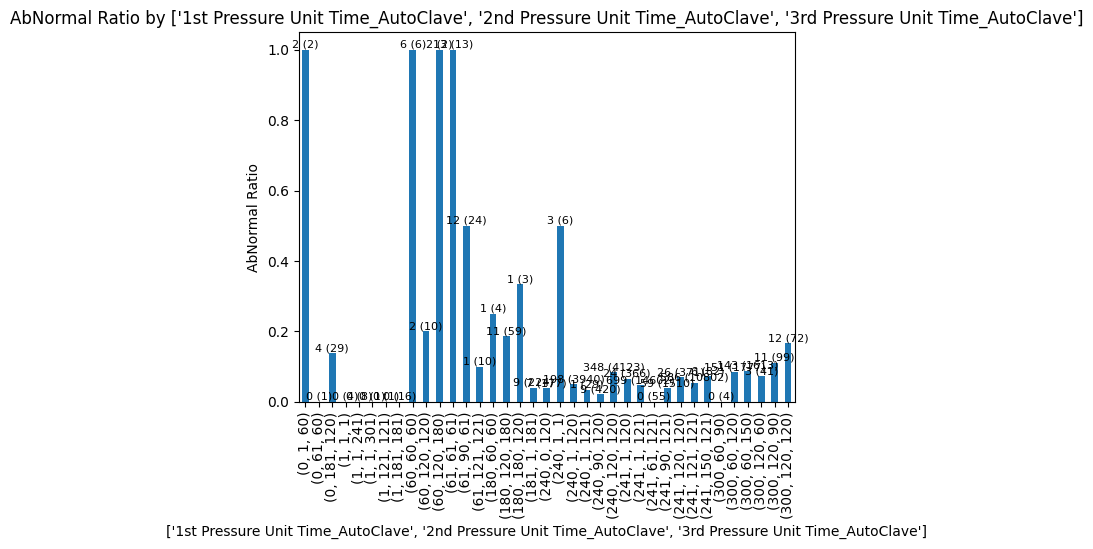

In [991]:
plot_ratio(train_data, [
    '1st Pressure Unit Time_AutoClave'
    , '2nd Pressure Unit Time_AutoClave'
    , '3rd Pressure Unit Time_AutoClave'
    ])

<Figure size 1000x500 with 0 Axes>

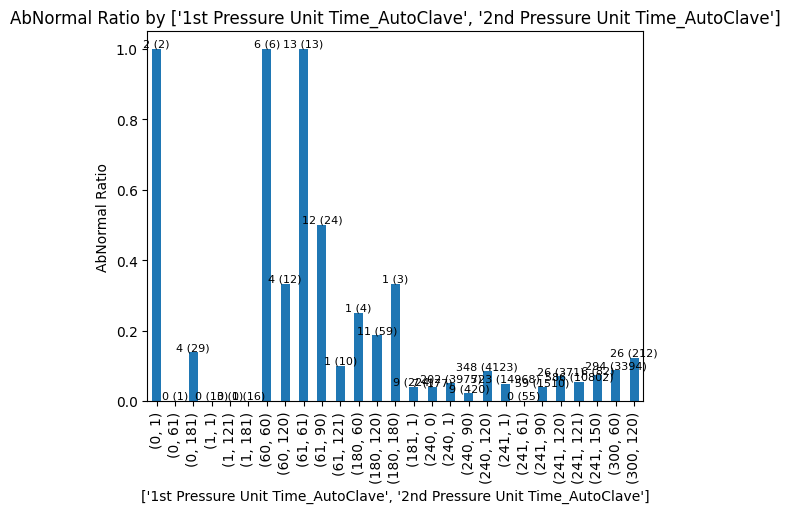

In [992]:
plot_ratio(train_data, [
    '1st Pressure Unit Time_AutoClave'
    , '2nd Pressure Unit Time_AutoClave'
    ])

압력 시간간에 그룹화 하였을때 비율값으로 1을 가지는 그룹이 3개 존재  
-> 단일변수보단 결합이나 파생변수 형식으로 활용시 성능향상 기대

In [993]:
summarize_group(train_data, [
    '1st Pressure Unit Time_AutoClave'
    , '2nd Pressure Unit Time_AutoClave'
    , '3rd Pressure Unit Time_AutoClave'
    , 'Chamber Temp. Unit Time_AutoClave'
    ])

Grouped by: 1st Pressure Unit Time_AutoClave, 2nd Pressure Unit Time_AutoClave, 3rd Pressure Unit Time_AutoClave, Chamber Temp. Unit Time_AutoClave

                   group  'AdNormal' count     ratio  Total
0         (0, 1, 60, 61)                 2  1.000000      2
1       (0, 61, 60, 121)                 0  0.000000      1
2     (0, 181, 120, 301)                 4  0.137931     29
3           (1, 1, 1, 3)                 0  0.000000      4
4       (1, 1, 241, 243)                 0  0.000000      8
5       (1, 1, 301, 303)                 0  0.000000      1
6     (1, 121, 121, 243)                 0  0.000000      1
7     (1, 181, 181, 363)                 0  0.000000     16
8      (60, 60, 60, 180)                 6  1.000000      6
9    (60, 120, 120, 300)                 2  0.200000     10
10   (60, 120, 180, 360)                 2  1.000000      2
11     (61, 61, 61, 183)                13  1.000000     13
12     (61, 90, 61, 212)                12  0.500000     24
13   (61, 1

Pressure(압력)의 1차,2차,3차 시간의 합은 Chamber Temp(온도)의 시간값과 동일

In [994]:
# '_AutoClave'를 포함하는 열 이름 필터링
train_data.filter(like='_AutoClave').columns

Index(['Model.Suffix_AutoClave', 'Workorder_AutoClave',
       '1st Pressure Collect Result_AutoClave',
       '1st Pressure Unit Time_AutoClave',
       '2nd Pressure Collect Result_AutoClave',
       '2nd Pressure Unit Time_AutoClave',
       '3rd Pressure Collect Result_AutoClave',
       '3rd Pressure Unit Time_AutoClave',
       'Chamber Temp. Collect Result_AutoClave',
       'Chamber Temp. Unit Time_AutoClave', 'Chamber_Temp_OKNG_AutoClave'],
      dtype='object')

### EDA : Chamber

In [995]:
# '_AutoClave'와 'Chamber'를 모두 포함하는 열 이름 필터링
train_data.filter(like='_AutoClave').filter(like='Chamber').columns

Index(['Chamber Temp. Collect Result_AutoClave',
       'Chamber Temp. Unit Time_AutoClave', 'Chamber_Temp_OKNG_AutoClave'],
      dtype='object')

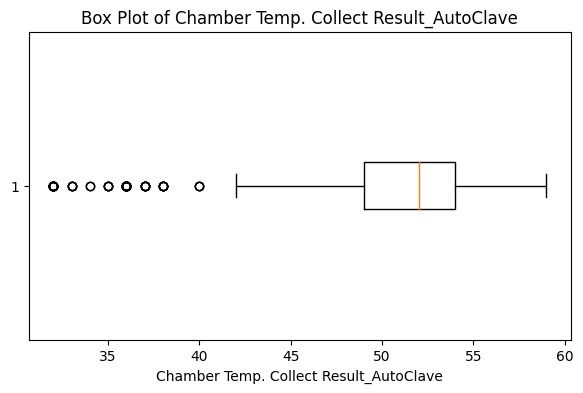

In [996]:
plot_box(train_data, 'Chamber Temp. Collect Result_AutoClave')

<Figure size 1000x500 with 0 Axes>

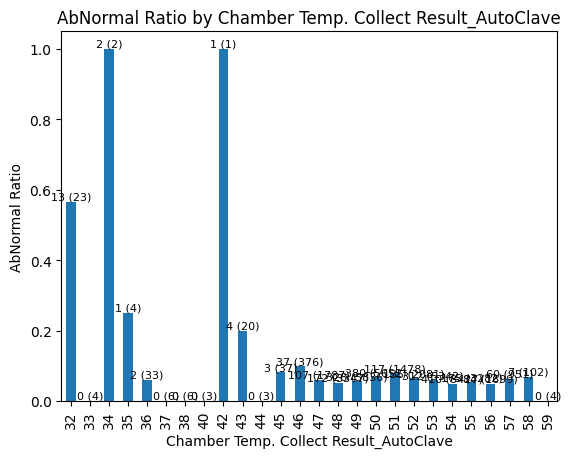

In [997]:
plot_ratio(train_data, 'Chamber Temp. Collect Result_AutoClave')

비정상(AbNormal) 비율이 1인 값이 존재하지만 갯수가 많지않음  
-> 다른 변수에 의해 나타난 비정상일수 있음

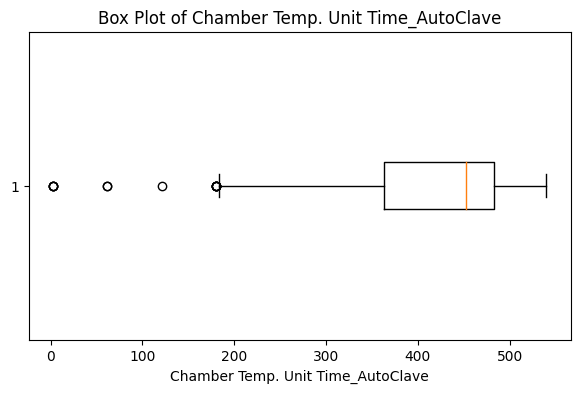

In [998]:
plot_box(train_data, 'Chamber Temp. Unit Time_AutoClave')

<Figure size 1000x500 with 0 Axes>

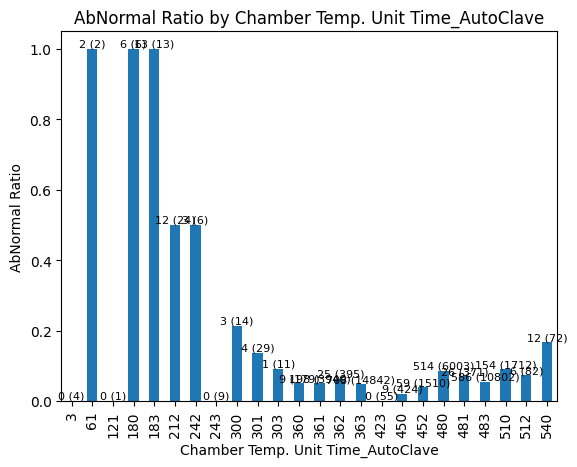

In [999]:
plot_ratio(train_data, 'Chamber Temp. Unit Time_AutoClave')

61 -> 360 으로 비율 감소 & 450 -> 540 비율 증가

Chamber Temp 온도와 시간 값을 곱하여 파생변수 생성

In [1000]:
# Chamber Temp x Chamber Temp Unit Time 계산
train_data['Chamber_Temp_x_AutoClave'] = train_data['Chamber Temp. Collect Result_AutoClave'] * train_data['Chamber Temp. Unit Time_AutoClave']
test_data['Chamber_Temp_x_AutoClave'] = test_data['Chamber Temp. Collect Result_AutoClave'] * test_data['Chamber Temp. Unit Time_AutoClave']

# 단계별 압력량 x 시간 계산
train_data['1st_Pressure_x_AutoClave'] = train_data['1st Pressure Collect Result_AutoClave'] * train_data['1st Pressure Unit Time_AutoClave']
train_data['2nd_Pressure_x_AutoClave'] = train_data['2nd Pressure Collect Result_AutoClave'] * train_data['2nd Pressure Unit Time_AutoClave']
train_data['3rd_Pressure_x_AutoClave'] = train_data['3rd Pressure Collect Result_AutoClave'] * train_data['3rd Pressure Unit Time_AutoClave']
train_data['All_Pressure_x_AutoClave'] = train_data['1st_Pressure_x_AutoClave'] + train_data['2nd_Pressure_x_AutoClave'] + train_data['3rd_Pressure_x_AutoClave']
train_data['All_Pressure_avg_AutoClave'] = train_data['All_Pressure_x_AutoClave'] / train_data['Chamber Temp. Unit Time_AutoClave']
train_data['All_Pressure_frac_tmep_AutoClave'] = train_data['All_Pressure_x_AutoClave'] / train_data['Chamber_Temp_x_AutoClave']

test_data['1st_Pressure_x_AutoClave'] = test_data['1st Pressure Collect Result_AutoClave'] * test_data['1st Pressure Unit Time_AutoClave']
test_data['2nd_Pressure_x_AutoClave'] = test_data['2nd Pressure Collect Result_AutoClave'] * test_data['2nd Pressure Unit Time_AutoClave']
test_data['3rd_Pressure_x_AutoClave'] = test_data['3rd Pressure Collect Result_AutoClave'] * test_data['3rd Pressure Unit Time_AutoClave']
test_data['All_Pressure_x_AutoClave'] = test_data['1st_Pressure_x_AutoClave'] + test_data['2nd_Pressure_x_AutoClave'] + test_data['3rd_Pressure_x_AutoClave']
test_data['All_Pressure_avg_AutoClave'] = test_data['All_Pressure_x_AutoClave'] / test_data['Chamber Temp. Unit Time_AutoClave']
test_data['All_Pressure_frac_tmep_AutoClave'] = test_data['All_Pressure_x_AutoClave'] / test_data['Chamber Temp. Unit Time_AutoClave']


<Figure size 1000x500 with 0 Axes>

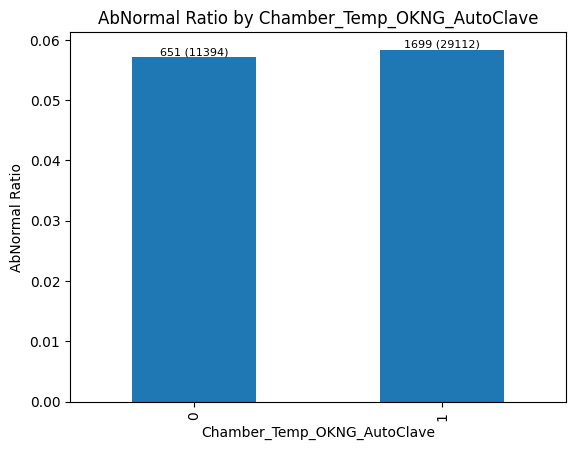

In [1001]:
plot_ratio(train_data, 'Chamber_Temp_OKNG_AutoClave')

압력변수와 온도변수의 파생변수를 생성할지에 대한 판단  
-> 다중공산성 및 변수중요도를 통해 

### 상관계수 및 다중공산성

In [1002]:
# '_AutoClave'를 포함하는 열 이름 필터링
auto_clave_columns = train_data.filter(like='_AutoClave').columns

# 필터링된 열들에 대해 info() 적용
train_data[auto_clave_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 18 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Model.Suffix_AutoClave                  40506 non-null  object 
 1   Workorder_AutoClave                     40506 non-null  object 
 2   1st Pressure Collect Result_AutoClave   40506 non-null  float64
 3   1st Pressure Unit Time_AutoClave        40506 non-null  int64  
 4   2nd Pressure Collect Result_AutoClave   40506 non-null  float64
 5   2nd Pressure Unit Time_AutoClave        40506 non-null  int64  
 6   3rd Pressure Collect Result_AutoClave   40506 non-null  float64
 7   3rd Pressure Unit Time_AutoClave        40506 non-null  int64  
 8   Chamber Temp. Collect Result_AutoClave  40506 non-null  int64  
 9   Chamber Temp. Unit Time_AutoClave       40506 non-null  int64  
 10  Chamber_Temp_OKNG_AutoClave             40506 non-null  in

상관계수 계산하는 코드에서 object 타입의 변수를 제외한 변수들로 상관계수를 계산하여 시각화 함

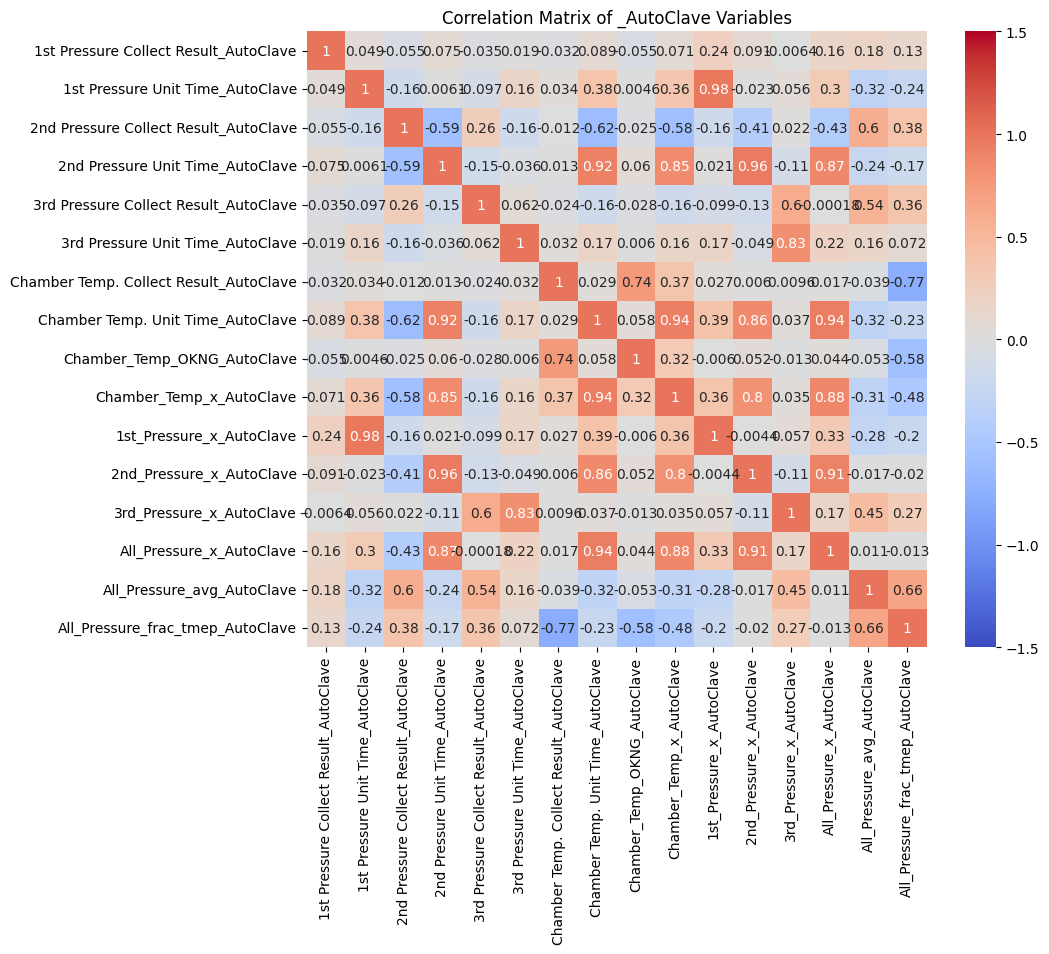

In [1003]:
# '_AutoClave'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_AutoClave').columns

# 필터링된 열들에 대해 상관계수 계산
correlation_matrix = train_data[Process_Desc_col].corr()

# 상관계수 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1.5, vmax=1.5)
plt.title('Correlation Matrix of _AutoClave Variables')
plt.show()

상관계수값 0.9이상인 Chamber Temp. Unit Time_AutoClave 와 2nd Pressure Unit Time_AutoClave  
두개의 변수중 Chamber Temp. Unit Time_AutoClave 변수를 제거

In [1004]:
# '_AutoClave'를 포함하는 열 이름 필터링
auto_clave_columns = train_data.filter(like='_AutoClave').columns

# 필터링된 열들에 대해 info() 적용
train_data[auto_clave_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 18 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Model.Suffix_AutoClave                  40506 non-null  object 
 1   Workorder_AutoClave                     40506 non-null  object 
 2   1st Pressure Collect Result_AutoClave   40506 non-null  float64
 3   1st Pressure Unit Time_AutoClave        40506 non-null  int64  
 4   2nd Pressure Collect Result_AutoClave   40506 non-null  float64
 5   2nd Pressure Unit Time_AutoClave        40506 non-null  int64  
 6   3rd Pressure Collect Result_AutoClave   40506 non-null  float64
 7   3rd Pressure Unit Time_AutoClave        40506 non-null  int64  
 8   Chamber Temp. Collect Result_AutoClave  40506 non-null  int64  
 9   Chamber Temp. Unit Time_AutoClave       40506 non-null  int64  
 10  Chamber_Temp_OKNG_AutoClave             40506 non-null  in

In [1005]:
# 삭제하려는 열 목록
columns_to_drop = [
    '1st Pressure Unit Time_AutoClave'
    , '2nd Pressure Unit Time_AutoClave'
    , '3rd Pressure Unit Time_AutoClave'
    ]

# 변수 제거
train_data = train_data.drop(columns=[col for col in columns_to_drop if col in train_data.columns])
test_data = test_data.drop(columns=[col for col in columns_to_drop if col in test_data.columns])

In [1006]:
# 변수 제거
train_data.drop(columns=['Chamber Temp. Unit Time_AutoClave'], inplace=True)
test_data.drop(columns=['Chamber Temp. Unit Time_AutoClave'], inplace=True)

In [1007]:
# 변수 제거
train_data.drop(columns=['All_Pressure_x_AutoClave'], inplace=True)
test_data.drop(columns=['All_Pressure_x_AutoClave'], inplace=True)

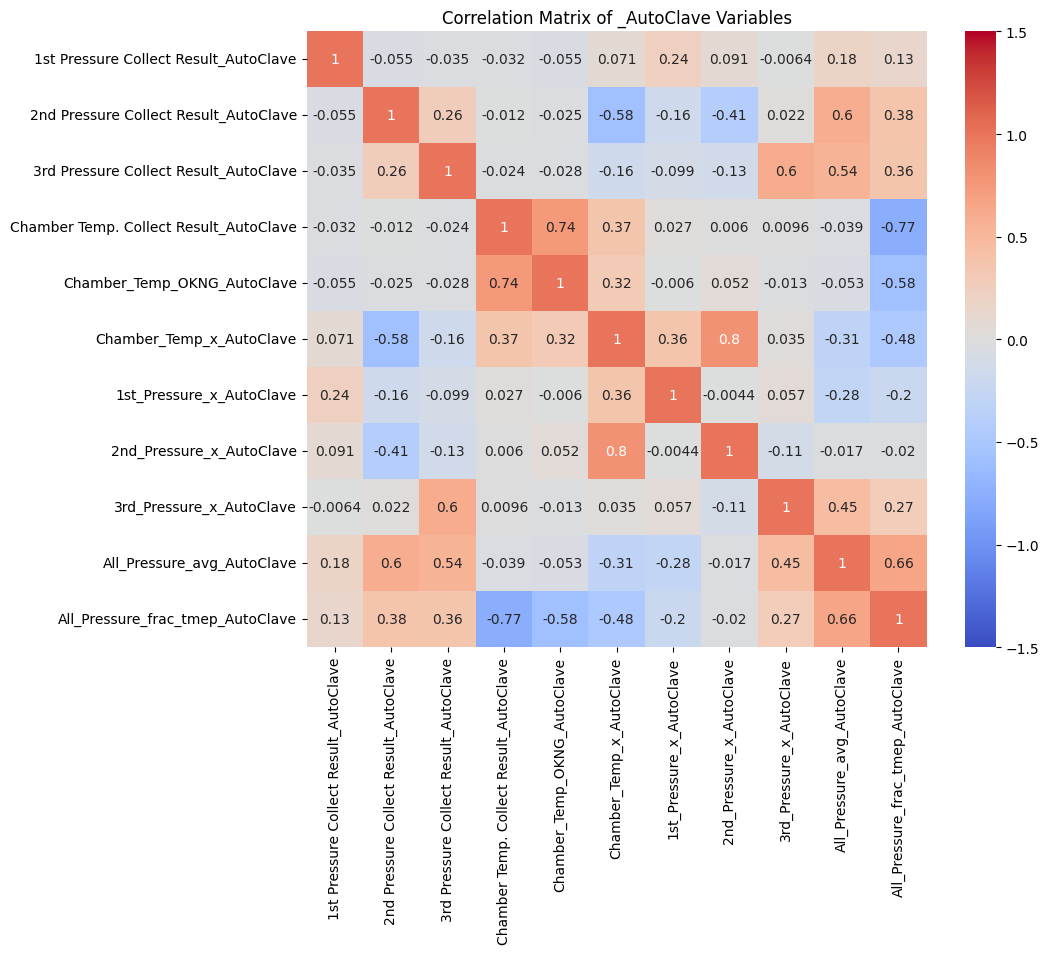

In [1008]:
# '_AutoClave'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_AutoClave').columns

# 필터링된 열들에 대해 상관계수 계산
correlation_matrix = train_data[Process_Desc_col].corr()

# 상관계수 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1.5, vmax=1.5)
plt.title('Correlation Matrix of _AutoClave Variables')
plt.show()

object 타입의 변수때문에 vif 계산이 안되어서 현재시점에서는 제거한후 vif 계산  
-> object 변수에 데한 인코딩 작업 필요

In [1009]:
# object 변수 제거
train_data_vif = train_data.drop(columns=['Model.Suffix_AutoClave', 'Workorder_AutoClave'])
test_data_vif = test_data.drop(columns=['Model.Suffix_AutoClave', 'Workorder_AutoClave'])

In [1010]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# '_AutoClave'를 포함하는 열 이름 필터링
Process_Desc_col = train_data_vif.filter(like='_AutoClave').columns

# 다중공선성(VIF) 계산
X = train_data[Process_Desc_col] 
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# VIF 값 출력
print(vif_data)

                                   Feature           VIF
0    1st Pressure Collect Result_AutoClave   3816.581859
1    2nd Pressure Collect Result_AutoClave     55.583610
2    3rd Pressure Collect Result_AutoClave    750.531233
3   Chamber Temp. Collect Result_AutoClave  11167.689330
4              Chamber_Temp_OKNG_AutoClave      7.835010
5                 Chamber_Temp_x_AutoClave   7252.354197
6                 1st_Pressure_x_AutoClave   1592.328361
7                 2nd_Pressure_x_AutoClave    220.971113
8                 3rd_Pressure_x_AutoClave   1402.613535
9               All_Pressure_avg_AutoClave  12709.536735
10        All_Pressure_frac_tmep_AutoClave   3273.117486


보통 VIF 값이 10이하로 만들어 두고 분석을 진행하는데 이부분에 대해서 보류  
-> 관련 변수간에 파생변수 생성을 통해 해결가능할거 같음

다시 원래 object 변수를 포함한 데이터를 이용

In [1011]:
# '_AutoClave'를 포함하는 열 이름 필터링
auto_clave_columns = train_data.filter(like='_AutoClave').columns

# 필터링된 열들에 대해 info() 적용
train_data[auto_clave_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Model.Suffix_AutoClave                  40506 non-null  object 
 1   Workorder_AutoClave                     40506 non-null  object 
 2   1st Pressure Collect Result_AutoClave   40506 non-null  float64
 3   2nd Pressure Collect Result_AutoClave   40506 non-null  float64
 4   3rd Pressure Collect Result_AutoClave   40506 non-null  float64
 5   Chamber Temp. Collect Result_AutoClave  40506 non-null  int64  
 6   Chamber_Temp_OKNG_AutoClave             40506 non-null  int64  
 7   Chamber_Temp_x_AutoClave                40506 non-null  int64  
 8   1st_Pressure_x_AutoClave                40506 non-null  float64
 9   2nd_Pressure_x_AutoClave                40506 non-null  float64
 10  3rd_Pressure_x_AutoClave                40506 non-null  fl

### 변수중요도

                                        importance
Workorder_AutoClave                       0.224905
All_Pressure_frac_tmep_AutoClave          0.128985
All_Pressure_avg_AutoClave                0.123321
1st_Pressure_x_AutoClave                  0.072478
Chamber_Temp_x_AutoClave                  0.068059
3rd_Pressure_x_AutoClave                  0.061693
2nd_Pressure_x_AutoClave                  0.060640
2nd Pressure Collect Result_AutoClave     0.059148
1st Pressure Collect Result_AutoClave     0.058110
3rd Pressure Collect Result_AutoClave     0.052962
Chamber Temp. Collect Result_AutoClave    0.049324
Model.Suffix_AutoClave                    0.033041
Chamber_Temp_OKNG_AutoClave               0.007336


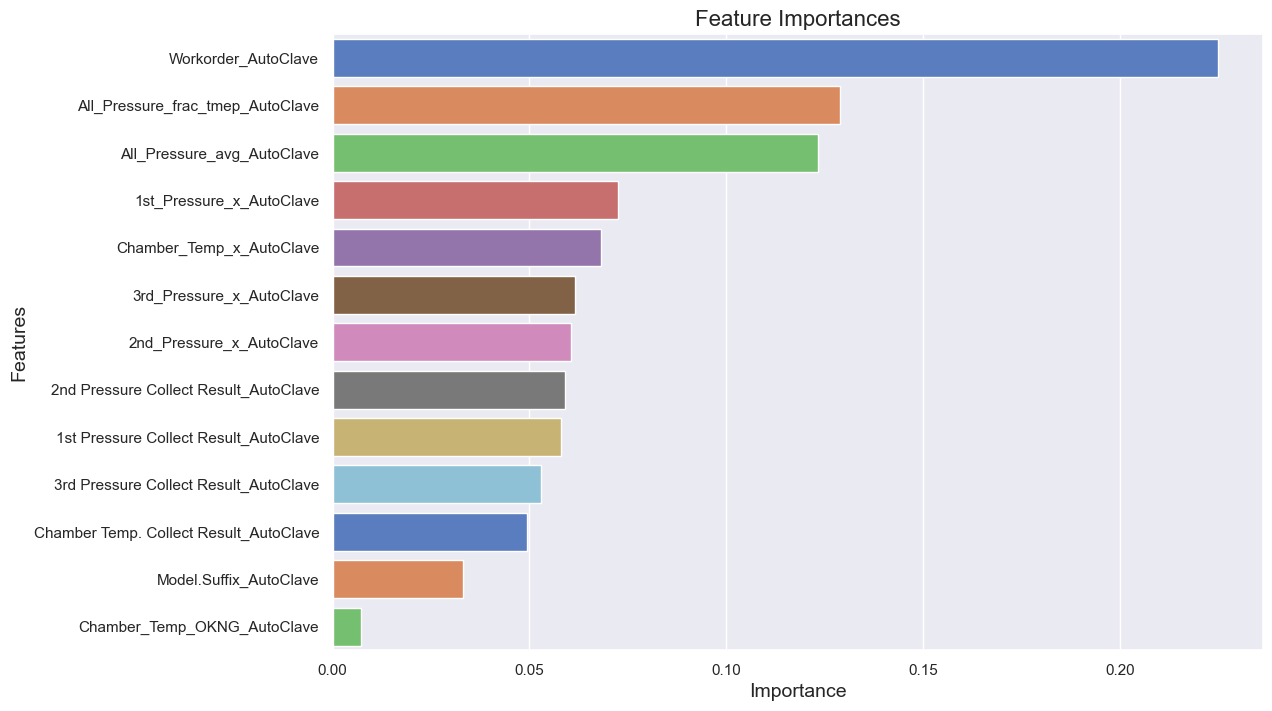

In [1013]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# '_AutoClave'를 포함하는 열 이름 필터링
auto_clave_columns = train_data.filter(like='_AutoClave').columns

# 데이터 전처리: 범주형 변수 인코딩
label_encoders = {}
for column in auto_clave_columns:
    if train_data[column].dtype == 'object':
        le = LabelEncoder()
        train_data[column] = le.fit_transform(train_data[column])
        label_encoders[column] = le

# 랜덤 포레스트 모델 학습
X = train_data[auto_clave_columns]
y = train_data['target']
model = RandomForestClassifier(random_state=RANDOM_STATE)
model.fit(X, y)

# 변수 중요도 계산
feature_importances = pd.DataFrame(model.feature_importances_, index=auto_clave_columns, columns=['importance']).sort_values('importance', ascending=False)

# 변수 중요도 출력
print(feature_importances)

# 변수 중요도 그래프로 출력
plt.figure(figsize=(12, 8))
sns.set(style="darkgrid")
sns.barplot(x=feature_importances['importance'], y=feature_importances.index, palette='muted')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Feature Importances', fontsize=16)
plt.show()

object 변수에 대해서 라벨인코딩을 진행한 후에 변수중요도를 판단함  
이때 Workorder_AutoClave 의 중요도가 높은 이유는 값종류가 663개를 그대로 라벨인코딩을 진행하여  
데이터에 대한 과적합? 느낌으로 된것이라 Workorder_AutoClave 값에 대해서 전처리 작업 필요

In [1014]:
# '_AutoClave'를 포함하는 열 이름 필터링
auto_clave_columns = train_data.filter(like='_AutoClave').columns

# 필터링된 열들에 대해 info() 적용
train_data[auto_clave_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Model.Suffix_AutoClave                  40506 non-null  int32  
 1   Workorder_AutoClave                     40506 non-null  int32  
 2   1st Pressure Collect Result_AutoClave   40506 non-null  float64
 3   2nd Pressure Collect Result_AutoClave   40506 non-null  float64
 4   3rd Pressure Collect Result_AutoClave   40506 non-null  float64
 5   Chamber Temp. Collect Result_AutoClave  40506 non-null  int64  
 6   Chamber_Temp_OKNG_AutoClave             40506 non-null  int64  
 7   Chamber_Temp_x_AutoClave                40506 non-null  int64  
 8   1st_Pressure_x_AutoClave                40506 non-null  float64
 9   2nd_Pressure_x_AutoClave                40506 non-null  float64
 10  3rd_Pressure_x_AutoClave                40506 non-null  fl

위의 변수들을 통해 모델 학습 진행

.